# ETAP 1

In [ ]:
# 📦 Importy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from BatchGenerator import BatchGenerator  # jeśli masz w osobnym pliku

In [2]:
# ✅ Wczytaj dane
data = np.load('data/pathmnist_224.npz')  # Upewnij się, że ścieżka jest poprawna
train_images = data['train_images']
train_labels = data['train_labels']
val_images = data['val_images']
val_labels = data['val_labels']
test_images = data['test_images']
test_labels = data['test_labels']

In [3]:
# 🔁 Inicjalizacja generatorów
train_gen = BatchGenerator(train_images, train_labels, batch_size=64, augment=False)
val_gen = BatchGenerator(val_images, val_labels, batch_size=64, augment=False)
test_gen = BatchGenerator(test_images, test_labels, batch_size=64, augment=False)

In [4]:
# 🏷️ Nazwy klas PathMNIST
class_names = [
    "adipose", "background", "debris", "lymphocytes",
    "mucus", "smooth muscle", "normal colon mucosa",
    "cancer-associated stroma", "colorectal adenocarcinoma epithelium"
]

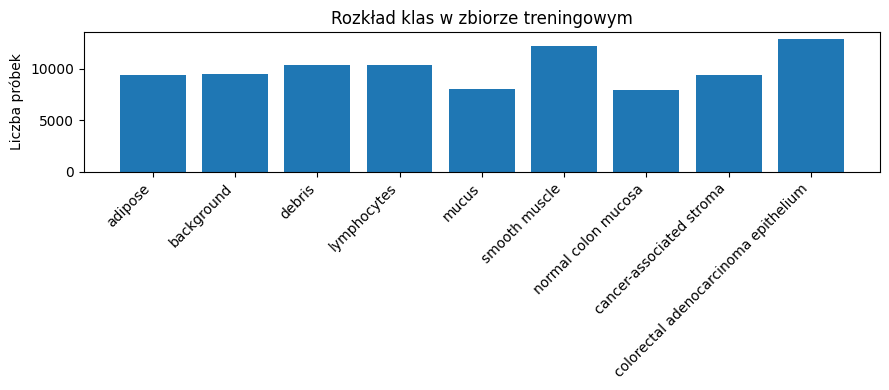

In [5]:
# 📊 Histogram rozkładu klas
label_counts = pd.Series(train_labels.flatten()).value_counts().sort_index()
plt.figure(figsize=(9, 4))
plt.bar(range(len(class_names)), label_counts.values, tick_label=class_names)
plt.xticks(rotation=45, ha='right')
plt.title("Rozkład klas w zbiorze treningowym")
plt.ylabel("Liczba próbek")
plt.tight_layout()
plt.show()

/var/folders/b0/xq85wq2n3gx3wg7bx4c6d_2h0000gn/T/ipykernel_6680/195058413.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(class_names[int(label)])


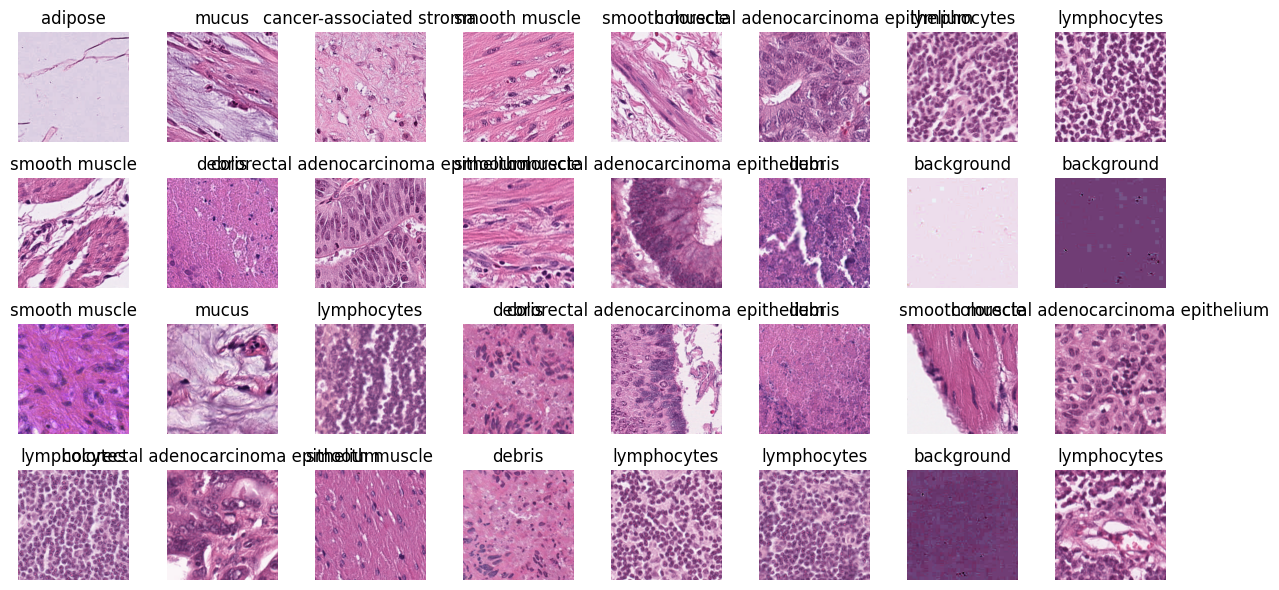

In [6]:
# 🖼️ Przykładowe obrazy z etykietami
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
axes = axes.flatten()
for img, label, ax in zip(train_images[:32], train_labels[:32], axes):
    ax.imshow(img)
    ax.set_title(class_names[int(label)])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# 📉 Próbkowanie pikseli RGB (~10 000 pikseli)
pixels_r, pixels_g, pixels_b = [], [], []
total_pixels = 0
sample_target = 10000

for batch_imgs, _ in train_gen:
    for img in batch_imgs:
        if total_pixels >= sample_target:
            break
        r, g, b = img[..., 0].flatten(), img[..., 1].flatten(), img[..., 2].flatten()
        pixels_r.extend(r)
        pixels_g.extend(g)
        pixels_b.extend(b)
        total_pixels += len(r)
    if total_pixels >= sample_target:
        break

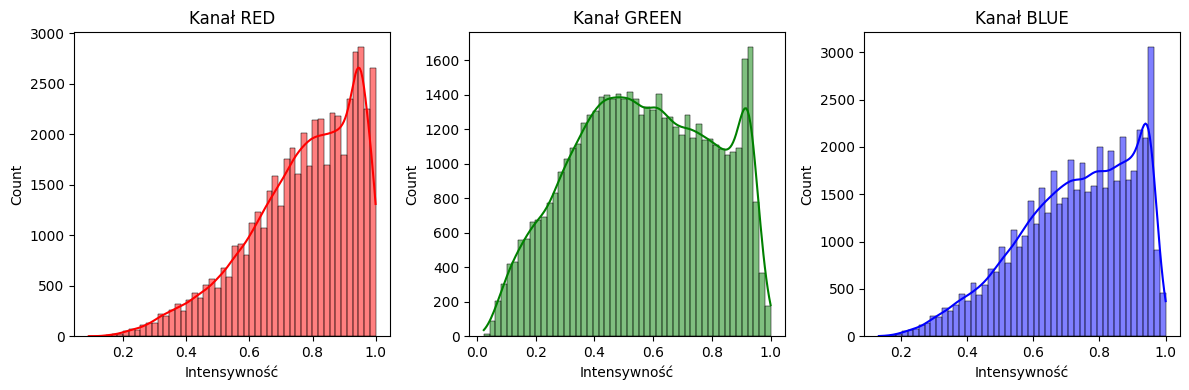

In [8]:
# 📊 Histogramy kanałów RGB
plt.figure(figsize=(12, 4))
for i, (channel, color) in enumerate(zip([pixels_r, pixels_g, pixels_b], ['red', 'green', 'blue'])):
    plt.subplot(1, 3, i + 1)
    sns.histplot(channel, bins=50, kde=True, color=color)
    plt.title(f'Kanał {color.upper()}')
    plt.xlabel('Intensywność')
plt.tight_layout()
plt.show()

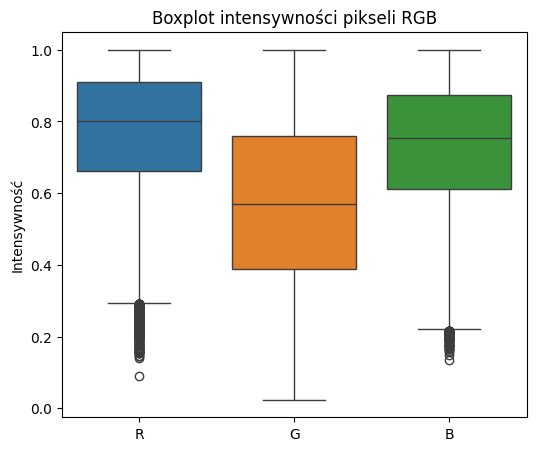

In [9]:
# 📦 Boxplot RGB
df_rgb = pd.DataFrame({'R': pixels_r, 'G': pixels_g, 'B': pixels_b})
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_rgb)
plt.title("Boxplot intensywności pikseli RGB")
plt.ylabel("Intensywność")
plt.show()

In [10]:
# 🧪 Test normalności Shapiro-Wilka (próbka 10k)
sample_r = df_rgb['R'].sample(10000, random_state=42)
sample_g = df_rgb['G'].sample(10000, random_state=42)
sample_b = df_rgb['B'].sample(10000, random_state=42)

shapiro_r = shapiro(sample_r)
shapiro_g = shapiro(sample_g)
shapiro_b = shapiro(sample_b)

print("Test Shapiro-Wilka (dla 10 000 próbek):")
print(f"R: stat={shapiro_r.statistic:.4f}, p={shapiro_r.pvalue:.4e}")
print(f"G: stat={shapiro_g.statistic:.4f}, p={shapiro_g.pvalue:.4e}")
print(f"B: stat={shapiro_b.statistic:.4f}, p={shapiro_b.pvalue:.4e}")

Test Shapiro-Wilka (dla 10 000 próbek):
R: stat=0.9408, p=1.2834e-52
G: stat=0.9736, p=2.8045e-39
B: stat=0.9565, p=2.7979e-47


/Users/krzysztof/Studies/sem2/umwdm/project/UMwDM/tf-env/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


# ETAP 2 – Przygotowanie danych (normalizacja, augmentacja, generatory)

In [11]:
# 🌀 Tworzenie generatorów
train_generator = BatchGenerator(train_images, train_labels, batch_size=64, augment=True)
val_generator   = BatchGenerator(val_images,   val_labels,   batch_size=64, augment=False)
test_generator  = BatchGenerator(test_images,  test_labels,  batch_size=64, augment=False)


In [12]:
# Pobranie batcha z augmentacją (tylko do wizualizacji)
augmented_images, augmented_labels = next(iter(train_generator))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.093768805..1.0231546].
/var/folders/b0/xq85wq2n3gx3wg7bx4c6d_2h0000gn/T/ipykernel_6680/1365355305.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(class_names[int(label)])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0037425256..0.9536412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07969719..1.0513076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.104867905..1.0042394].
Clipping input data to the valid range for imshow with RGB data ([0..1] f

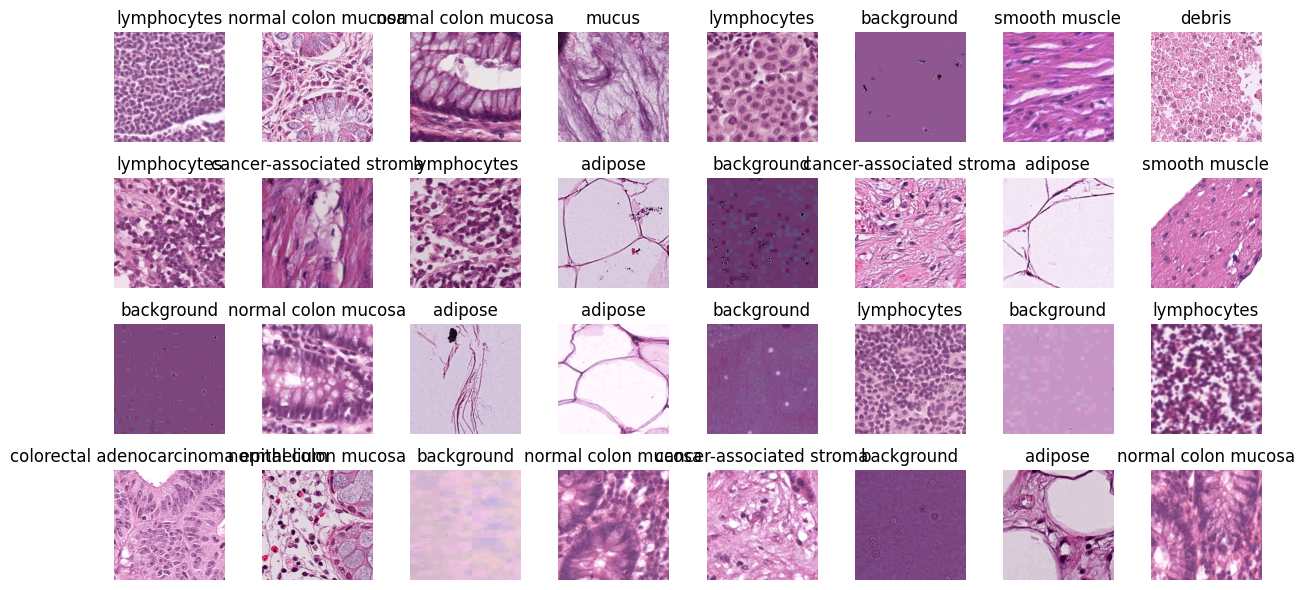

In [13]:
# Wyświetlenie 32 przykładowych obrazów
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
axes = axes.flatten()
for img, label, ax in zip(augmented_images[:32], augmented_labels[:32], axes):
    ax.imshow(img)
    ax.set_title(class_names[int(label)])
    ax.axis('off')
plt.tight_layout()
plt.show()

# 🧠 ETAP 3 – Model bazowy CNN

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam

In [15]:
# 🎯 Model bazowy CNN
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')  # 9 klas
])


/Users/krzysztof/Studies/sem2/umwdm/project/UMwDM/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# ⚙️ Kompilacja modelu
model_cnn.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',  # bo etykiety są liczbami (nie one-hot)
    metrics=['accuracy']
)

In [18]:
# ⏱️ Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

In [19]:
# Callback do zapisu modelu po każdej epoce
checkpoint_cb = ModelCheckpoint(
    filepath="model_epoch_{epoch:02d}.h5",  # zapisuj jako model_epoch_01.h5 itd.
    save_weights_only=False,               # zapisuje cały model (architektura + wagi)
    save_best_only=False,                  # zapisuje każdy model, nie tylko najlepszy
    verbose=1
)

In [20]:
# Callback do logowania loss/accuracy po każdej epoce
csv_logger_cb = CSVLogger("training_log.csv", append=True)

In [21]:
# Trening
history_cnn = model_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[early_stop, checkpoint_cb, csv_logger_cb]
)

Epoch 1/40


/Users/krzysztof/Studies/sem2/umwdm/project/UMwDM/tf-env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.2850 - loss: 2.3687
Epoch 1: saving model to model_epoch_01.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 491s 348ms/step - accuracy: 0.2851 - loss: 2.3682 - val_accuracy: 0.6046 - val_loss: 1.0343
Epoch 2/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.5397 - loss: 1.1692
Epoch 2: saving model to model_epoch_02.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 493s 350ms/step - accuracy: 0.5397 - loss: 1.1692 - val_accuracy: 0.6832 - val_loss: 0.8339
Epoch 3/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6098 - loss: 1.0082
Epoch 3: saving model to model_epoch_03.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 490s 348ms/step - accuracy: 0.6098 - loss: 1.0082 - val_accuracy: 0.7392 - val_loss: 0.7114
Epoch 4/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6586 - loss: 0.8872
Epoch 4: saving model to model_epoch_04.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 492s 350ms/step - accuracy: 0.6586 - loss: 0.8872 - val_accuracy: 0.7820 - val_loss: 0.6257
Epoch 5/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6893 - loss: 0.8173
Epoch 5: saving model to model_epoch_05.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 492s 350ms/step - accuracy: 0.6893 - loss: 0.8172 - val_accuracy: 0.8159 - val_loss: 0.5454
Epoch 6/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7171 - loss: 0.7551
Epoch 6: saving model to model_epoch_06.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 493s 351ms/step - accuracy: 0.7171 - loss: 0.7550 - val_accuracy: 0.8330 - val_loss: 0.5268
Epoch 7/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7300 - loss: 0.7223
Epoch 7: saving model to model_epoch_07.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 492s 350ms/step - accuracy: 0.7300 - loss: 0.7223 - val_accuracy: 0.8320 - val_loss: 0.4811
Epoch 8/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7482 - loss: 0.6734
Epoch 8: saving model to model_epoch_08.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 492s 350ms/step - accuracy: 0.7482 - loss: 0.6734 - val_accuracy: 0.8532 - val_loss: 0.4112
Epoch 9/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7563 - loss: 0.6515
Epoch 9: saving model to model_epoch_09.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 493s 350ms/step - accuracy: 0.7563 - loss: 0.6515 - val_accuracy: 0.8626 - val_loss: 0.4172
Epoch 10/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7702 - loss: 0.6188
Epoch 10: saving model to model_epoch_10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 492s 349ms/step - accuracy: 0.7703 - loss: 0.6188 - val_accuracy: 0.8647 - val_loss: 0.3916
Epoch 11/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7841 - loss: 0.5849
Epoch 11: saving model to model_epoch_11.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 494s 351ms/step - accuracy: 0.7841 - loss: 0.5849 - val_accuracy: 0.8868 - val_loss: 0.3876
Epoch 12/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7970 - loss: 0.5513
Epoch 12: saving model to model_epoch_12.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 493s 350ms/step - accuracy: 0.7970 - loss: 0.5513 - val_accuracy: 0.8746 - val_loss: 0.3854
Epoch 13/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8068 - loss: 0.5305
Epoch 13: saving model to model_epoch_13.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 492s 350ms/step - accuracy: 0.8068 - loss: 0.5305 - val_accuracy: 0.8783 - val_loss: 0.3768
Epoch 14/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8128 - loss: 0.5182
Epoch 14: saving model to model_epoch_14.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 493s 350ms/step - accuracy: 0.8128 - loss: 0.5181 - val_accuracy: 0.8557 - val_loss: 0.4227
Epoch 15/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8215 - loss: 0.4959
Epoch 15: saving model to model_epoch_15.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 496s 353ms/step - accuracy: 0.8215 - loss: 0.4959 - val_accuracy: 0.8826 - val_loss: 0.3462
Epoch 16/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8264 - loss: 0.4762
Epoch 16: saving model to model_epoch_16.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 489s 347ms/step - accuracy: 0.8264 - loss: 0.4762 - val_accuracy: 0.8838 - val_loss: 0.4090
Epoch 17/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8337 - loss: 0.4637
Epoch 17: saving model to model_epoch_17.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 489s 347ms/step - accuracy: 0.8337 - loss: 0.4637 - val_accuracy: 0.9056 - val_loss: 0.3017
Epoch 18/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8377 - loss: 0.4595
Epoch 18: saving model to model_epoch_18.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 489s 348ms/step - accuracy: 0.8377 - loss: 0.4595 - val_accuracy: 0.8988 - val_loss: 0.3155
Epoch 19/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8526 - loss: 0.4217
Epoch 19: saving model to model_epoch_19.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 489s 348ms/step - accuracy: 0.8526 - loss: 0.4217 - val_accuracy: 0.9157 - val_loss: 0.2807
Epoch 20/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8486 - loss: 0.4347
Epoch 20: saving model to model_epoch_20.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 490s 348ms/step - accuracy: 0.8485 - loss: 0.4347 - val_accuracy: 0.8255 - val_loss: 0.5158
Epoch 21/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8579 - loss: 0.4102
Epoch 21: saving model to model_epoch_21.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 489s 347ms/step - accuracy: 0.8579 - loss: 0.4101 - val_accuracy: 0.9016 - val_loss: 0.2920
Epoch 22/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8832 - loss: 0.3474
Epoch 22: saving model to model_epoch_22.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 489s 348ms/step - accuracy: 0.8832 - loss: 0.3474 - val_accuracy: 0.9218 - val_loss: 0.2385
Epoch 23/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8907 - loss: 0.3262
Epoch 23: saving model to model_epoch_23.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 487s 346ms/step - accuracy: 0.8907 - loss: 0.3262 - val_accuracy: 0.9251 - val_loss: 0.2319
Epoch 24/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8917 - loss: 0.3194
Epoch 24: saving model to model_epoch_24.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 487s 346ms/step - accuracy: 0.8917 - loss: 0.3194 - val_accuracy: 0.8841 - val_loss: 0.3282
Epoch 25/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.8975 - loss: 0.3058
Epoch 25: saving model to model_epoch_25.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 484s 344ms/step - accuracy: 0.8975 - loss: 0.3058 - val_accuracy: 0.8950 - val_loss: 0.2999
Epoch 26/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9006 - loss: 0.2939
Epoch 26: saving model to model_epoch_26.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 484s 344ms/step - accuracy: 0.9006 - loss: 0.2939 - val_accuracy: 0.9255 - val_loss: 0.2261
Epoch 27/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9030 - loss: 0.2840
Epoch 27: saving model to model_epoch_27.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 484s 344ms/step - accuracy: 0.9030 - loss: 0.2840 - val_accuracy: 0.9303 - val_loss: 0.2083
Epoch 28/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9055 - loss: 0.2869
Epoch 28: saving model to model_epoch_28.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 483s 343ms/step - accuracy: 0.9055 - loss: 0.2869 - val_accuracy: 0.9128 - val_loss: 0.2592
Epoch 29/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9086 - loss: 0.2722
Epoch 29: saving model to model_epoch_29.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 483s 343ms/step - accuracy: 0.9086 - loss: 0.2722 - val_accuracy: 0.9207 - val_loss: 0.2412
Epoch 30/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9095 - loss: 0.2692
Epoch 30: saving model to model_epoch_30.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 485s 345ms/step - accuracy: 0.9095 - loss: 0.2692 - val_accuracy: 0.9141 - val_loss: 0.2553
Epoch 31/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9093 - loss: 0.2708
Epoch 31: saving model to model_epoch_31.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 485s 345ms/step - accuracy: 0.9093 - loss: 0.2708 - val_accuracy: 0.9146 - val_loss: 0.2250
Epoch 32/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9146 - loss: 0.2565
Epoch 32: saving model to model_epoch_32.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 488s 347ms/step - accuracy: 0.9146 - loss: 0.2565 - val_accuracy: 0.9069 - val_loss: 0.2486
Epoch 33/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9144 - loss: 0.2553
Epoch 33: saving model to model_epoch_33.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 488s 347ms/step - accuracy: 0.9144 - loss: 0.2553 - val_accuracy: 0.9303 - val_loss: 0.2088
Epoch 34/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9165 - loss: 0.2568
Epoch 34: saving model to model_epoch_34.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 490s 348ms/step - accuracy: 0.9165 - loss: 0.2568 - val_accuracy: 0.9346 - val_loss: 0.1935
Epoch 35/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9179 - loss: 0.2495
Epoch 35: saving model to model_epoch_35.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 489s 348ms/step - accuracy: 0.9179 - loss: 0.2495 - val_accuracy: 0.9284 - val_loss: 0.2212
Epoch 36/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9141 - loss: 0.2565
Epoch 36: saving model to model_epoch_36.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 488s 347ms/step - accuracy: 0.9142 - loss: 0.2565 - val_accuracy: 0.9370 - val_loss: 0.1808
Epoch 37/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9186 - loss: 0.2421
Epoch 37: saving model to model_epoch_37.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 488s 347ms/step - accuracy: 0.9186 - loss: 0.2421 - val_accuracy: 0.9027 - val_loss: 0.2660
Epoch 38/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9167 - loss: 0.2446
Epoch 38: saving model to model_epoch_38.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 491s 349ms/step - accuracy: 0.9167 - loss: 0.2446 - val_accuracy: 0.9307 - val_loss: 0.2009
Epoch 39/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9189 - loss: 0.2432
Epoch 39: saving model to model_epoch_39.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 491s 349ms/step - accuracy: 0.9189 - loss: 0.2432 - val_accuracy: 0.8954 - val_loss: 0.2789
Epoch 40/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9190 - loss: 0.2447
Epoch 40: saving model to model_epoch_40.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 492s 349ms/step - accuracy: 0.9190 - loss: 0.2447 - val_accuracy: 0.9295 - val_loss: 0.1963


In [26]:
# 📊 Ocena na zbiorze testowym
test_loss, test_acc = model_cnn.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.8879 - loss: 9.1910
Test accuracy: 0.8848 | Test loss: 7.9510


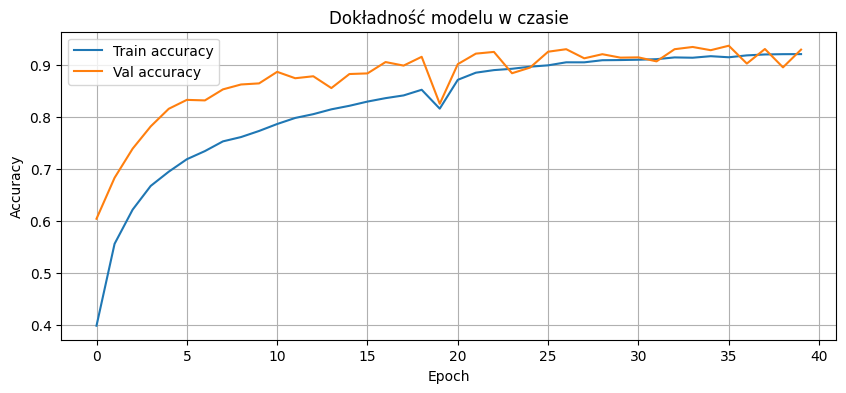

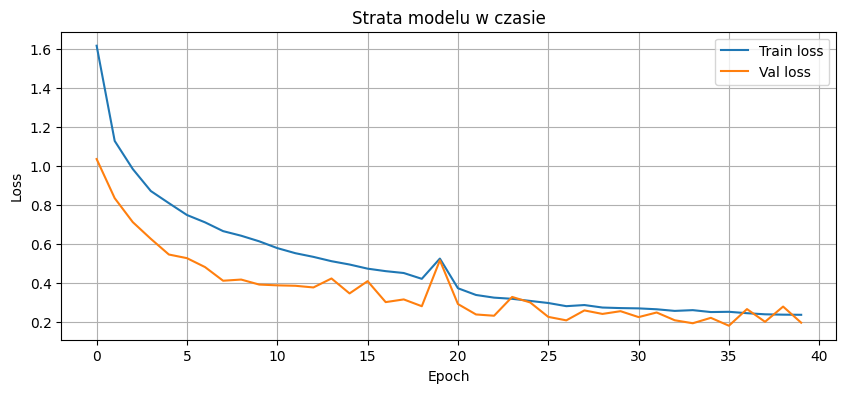

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(history_cnn.history['accuracy'], label='Train accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Dokładność modelu w czasie")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history_cnn.history['loss'], label='Train loss')
plt.plot(history_cnn.history['val_loss'], label='Val loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Strata modelu w czasie")
plt.legend()
plt.grid(True)
plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step
                                      precision    recall  f1-score   support

                             adipose       1.00      0.97      0.98      1338
                          background       0.92      1.00      0.96       847
                              debris       0.57      0.97      0.72       339
                         lymphocytes       0.99      0.96      0.97       634
                               mucus       0.96      0.85      0.90      1035
                       smooth muscle       0.77      0.70      0.73       592
                 normal colon mucosa       0.78      0.93      0.85       741
            cancer-associated stroma       0.76      0.41      0.53       421
colorectal adenocarcinoma epithelium       0.94      0.90      0.92      1233

                            accuracy                           0.88      7180
                           macro avg       0.85      0.86      0.84      7180
                    

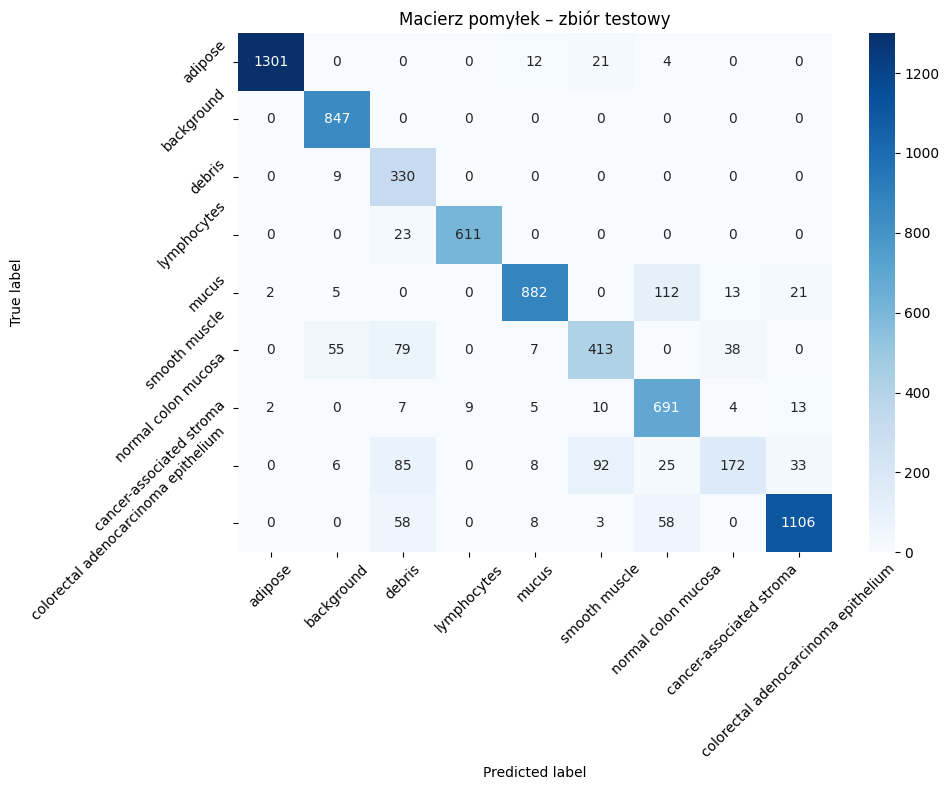

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Wyraźnie normalizuj dane
X_test = test_images.astype('float32') / 255.0
y_true = test_labels.flatten()

# 🔮 Predykcja
y_pred = model_cnn.predict(X_test, batch_size=64, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# 🧾 Raport
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# 🔳 Macierz pomyłek
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Macierz pomyłek – zbiór testowy")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


# ETAP 4

In [45]:
# 🧠 Nowy ulepszony model CNN
model_cnn_improved = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.30),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.35),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

/Users/krzysztof/Studies/sem2/umwdm/project/UMwDM/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
# ⚙️ Kompilacja
model_cnn_improved.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [48]:
# ✅ Zapis modelu co epokę z numerem (model_epoch_XX.h5)
checkpoint_all = ModelCheckpoint(
    filepath='model_improved_epoch_{epoch:02d}.h5',
    save_weights_only=False,
    save_freq='epoch'
)

# ✅ Zapis najlepszego modelu (niskie val_loss)
checkpoint_best = ModelCheckpoint(
    filepath='model_improved_best.h5',
    monitor='val_loss',
    save_weights_only=False,
    save_best_only=True
)

In [50]:
# 🔁 Trening modelu
history_improved = model_cnn_improved.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint_best, checkpoint_all],
)

Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.2573 - loss: 1.9484

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1036s 736ms/step - accuracy: 0.2573 - loss: 1.9484 - val_accuracy: 0.1449 - val_loss: 2.5496
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.3343 - loss: 1.7719

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1035s 736ms/step - accuracy: 0.3343 - loss: 1.7718 - val_accuracy: 0.4577 - val_loss: 1.8823
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.3868 - loss: 1.6200

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1039s 738ms/step - accuracy: 0.3868 - loss: 1.6199 - val_accuracy: 0.3974 - val_loss: 1.5066
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.3862 - loss: 1.6388

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1053s 748ms/step - accuracy: 0.3862 - loss: 1.6388 - val_accuracy: 0.2740 - val_loss: 1.8405
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.4220 - loss: 1.5290

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1024s 728ms/step - accuracy: 0.4220 - loss: 1.5289 - val_accuracy: 0.5988 - val_loss: 1.1835
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.4602 - loss: 1.4355

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1021s 726ms/step - accuracy: 0.4602 - loss: 1.4354 - val_accuracy: 0.5237 - val_loss: 2.9146
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.5181 - loss: 1.2964

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1027s 730ms/step - accuracy: 0.5181 - loss: 1.2964 - val_accuracy: 0.5984 - val_loss: 1.5426
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.5393 - loss: 1.2426

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1023s 727ms/step - accuracy: 0.5393 - loss: 1.2426 - val_accuracy: 0.5447 - val_loss: 2.1069
Epoch 9/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.5847 - loss: 1.1186

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1024s 727ms/step - accuracy: 0.5848 - loss: 1.1186 - val_accuracy: 0.6694 - val_loss: 0.9554
Epoch 10/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.6394 - loss: 0.9580

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1018s 723ms/step - accuracy: 0.6395 - loss: 0.9580 - val_accuracy: 0.5556 - val_loss: 2.1019
Epoch 11/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.6831 - loss: 0.8596

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1020s 725ms/step - accuracy: 0.6831 - loss: 0.8596 - val_accuracy: 0.5692 - val_loss: 2.8133
Epoch 12/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.7268 - loss: 0.7708

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1019s 724ms/step - accuracy: 0.7269 - loss: 0.7708 - val_accuracy: 0.6362 - val_loss: 3.3968
Epoch 13/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.7789 - loss: 0.6252

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1018s 724ms/step - accuracy: 0.7789 - loss: 0.6251 - val_accuracy: 0.7850 - val_loss: 1.5178
Epoch 14/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.8156 - loss: 0.5277

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1020s 725ms/step - accuracy: 0.8156 - loss: 0.5277 - val_accuracy: 0.8641 - val_loss: 0.6341
Epoch 15/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.8390 - loss: 0.4712

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1016s 722ms/step - accuracy: 0.8390 - loss: 0.4712 - val_accuracy: 0.6929 - val_loss: 2.3337
Epoch 16/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.8688 - loss: 0.3923

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1032s 734ms/step - accuracy: 0.8688 - loss: 0.3923 - val_accuracy: 0.6849 - val_loss: 3.6411
Epoch 17/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.8846 - loss: 0.3554

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1027s 730ms/step - accuracy: 0.8846 - loss: 0.3554 - val_accuracy: 0.8726 - val_loss: 0.8302
Epoch 18/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.8916 - loss: 0.3318

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1018s 724ms/step - accuracy: 0.8916 - loss: 0.3318 - val_accuracy: 0.8696 - val_loss: 1.0683
Epoch 19/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.9096 - loss: 0.2850

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1021s 726ms/step - accuracy: 0.9096 - loss: 0.2850 - val_accuracy: 0.8104 - val_loss: 2.0923
Epoch 20/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.9139 - loss: 0.2716

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1019s 725ms/step - accuracy: 0.9139 - loss: 0.2716 - val_accuracy: 0.5625 - val_loss: 6.9636


In [58]:
from tensorflow.keras.models import load_model

# Wczytaj najlepszy model (np. epoka 17 — zależnie od twoich zapisów)
model_best = load_model("model_improved_best.h5")

# 📊 Ocena na zbiorze testowym
test_loss_improved, test_acc_improved = model_best.evaluate(test_generator)
print(f"Test accuracy: {test_acc_improved:.4f} | Test loss: {test_loss_improved:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.8689 - loss: 3.5829
Test accuracy: 0.8648 | Test loss: 3.4207


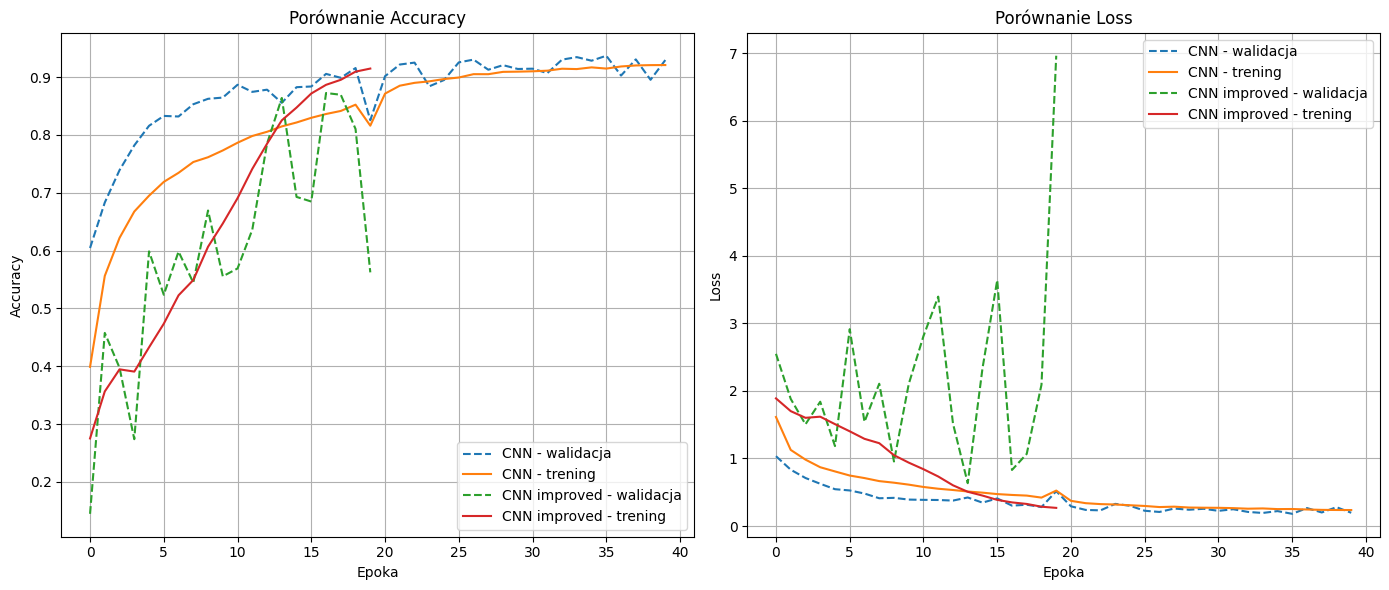

In [ ]:
# 🔍 Porównanie wyników trenowania modeli bazowego i ulepszonego

# Zakładamy, że istnieją obiekty: history_cnn i history_improved
plt.figure(figsize=(14, 6))

# 📈 Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['val_accuracy'], label='CNN - walidacja', linestyle='--')
plt.plot(history_cnn.history['accuracy'], label='CNN - trening')
plt.plot(history_improved.history['val_accuracy'], label='CNN improved - walidacja', linestyle='--')
plt.plot(history_improved.history['accuracy'], label='CNN improved - trening')
plt.title('Porównanie Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 📉 Loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['val_loss'], label='CNN - walidacja', linestyle='--')
plt.plot(history_cnn.history['loss'], label='CNN - trening')
plt.plot(history_improved.history['val_loss'], label='CNN improved - walidacja', linestyle='--')
plt.plot(history_improved.history['loss'], label='CNN improved - trening')
plt.title('Porównanie Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step
                                      precision    recall  f1-score   support

                             adipose       0.98      0.97      0.98      1338
                          background       0.93      1.00      0.96       847
                              debris       0.97      0.58      0.72       339
                         lymphocytes       0.96      0.99      0.98       634
                               mucus       0.90      0.77      0.83      1035
                       smooth muscle       0.65      0.89      0.75       592
                 normal colon mucosa       0.68      0.77      0.72       741
            cancer-associated stroma       0.78      0.47      0.58       421
colorectal adenocarcinoma epithelium       0.88      0.93      0.90      1233

                            accuracy                           0.86      7180
                           macro avg       0.86      0.82      0.83      7180
                  

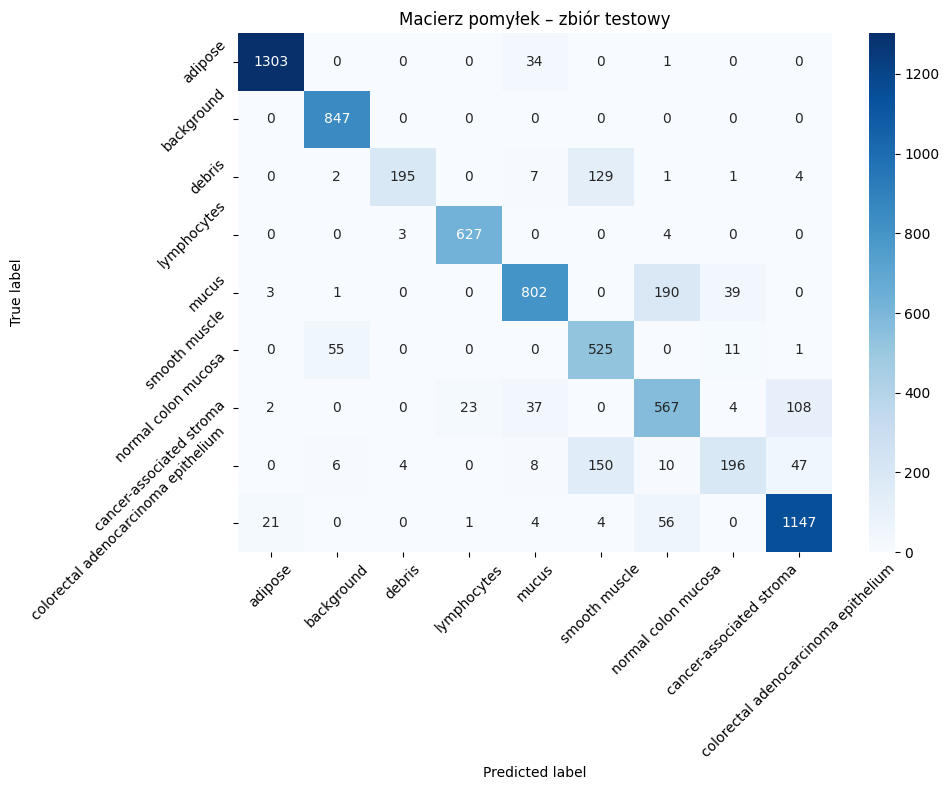

In [60]:
# ✅ Wyraźnie normalizuj dane
X_test_improved = test_images.astype('float32') / 255.0
y_true_improved = test_labels.flatten()

# 🔮 Predykcja
y_pred_improved = model_best.predict(X_test_improved, batch_size=64, verbose=1)
y_pred_classes_improved = np.argmax(y_pred_improved, axis=1)

# 🧾 Raport
print(classification_report(y_true_improved, y_pred_classes_improved, target_names=class_names))

# 🔳 Macierz pomyłek
cm = confusion_matrix(y_true_improved, y_pred_classes_improved)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Macierz pomyłek – zbiór testowy")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

/Users/krzysztof/Studies/sem2/umwdm/project/UMwDM/tf-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


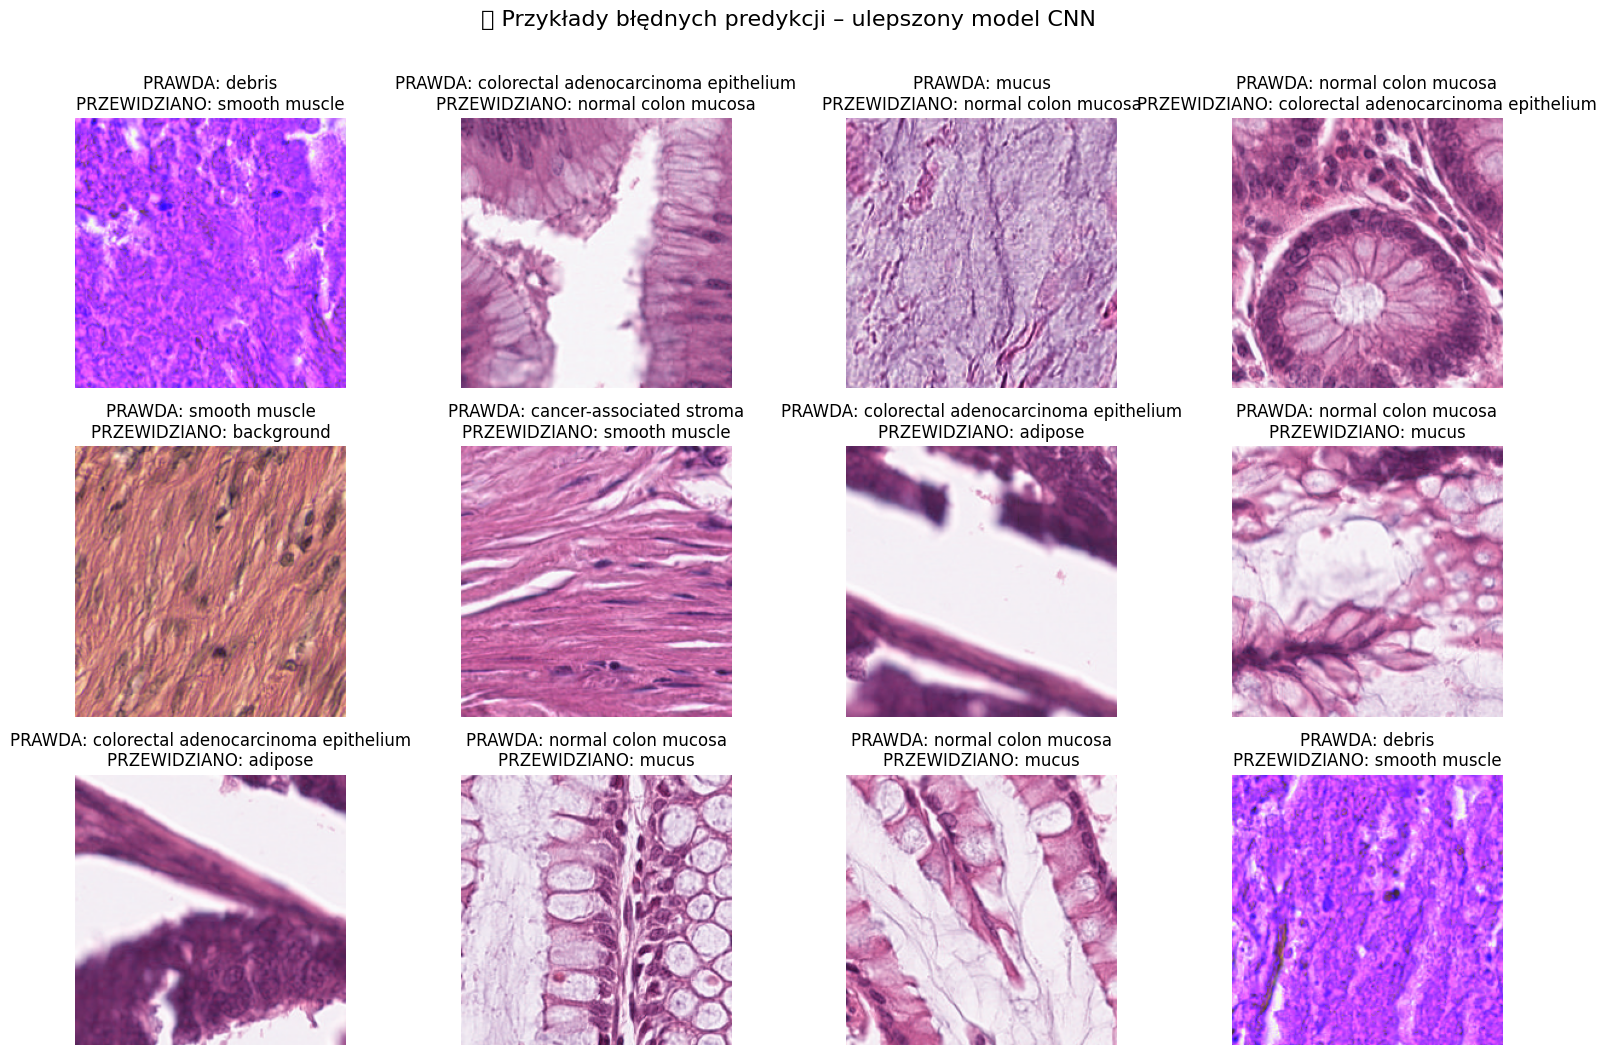

In [61]:
# 🔄 Zresetuj generator i przeprowadź predykcję
test_generator_vis = BatchGenerator(test_images, test_labels, batch_size=64, augment=False)

y_true = []
y_pred = []
images_all = []

# Pętla zabezpieczona przed końcem sekwencji
for batch_images, batch_labels in test_generator_vis:
    if batch_images.shape[0] == 0:
        break  # koniec danych
    preds = model_best.predict(batch_images, verbose=0)
    y_true.extend(batch_labels.flatten())
    y_pred.extend(np.argmax(preds, axis=1))
    images_all.extend(batch_images)

# Zamiana na tablice numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)
images_all = np.array(images_all)

# 🧪 Błędne predykcje
wrong_idx = np.where(y_true != y_pred)[0]
if len(wrong_idx) == 0:
    print("Brak błędnych predykcji – model działa idealnie (lub coś poszło nie tak)")
else:
    sample_wrong = np.random.choice(wrong_idx, size=min(12, len(wrong_idx)), replace=False)

    # 🔍 Wizualizacja
    plt.figure(figsize=(16, 10))
    for i, idx in enumerate(sample_wrong):
        plt.subplot(3, 4, i + 1)
        plt.imshow(np.clip(images_all[idx], 0, 1))
        plt.title(f"PRAWDA: {class_names[y_true[idx]]}\nPRZEWIDZIANO: {class_names[y_pred[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle("🔍 Przykłady błędnych predykcji – ulepszony model CNN", fontsize=16, y=1.05)
    plt.show()


# PCA + SVM

In [72]:
# 🔄 Wczytaj dane z lokalnego pliku pathmnist.npz
path = "./data/pathmnist.npz"  # Upewnij się, że jesteś w tym folderze lub zmień ścieżkę
data_svm = np.load(path)

# 🧠 Załaduj dane pod zmienne SVM
X_train_svm = data_svm["train_images"].astype(np.float32) / 255.0
X_val_svm = data_svm["val_images"].astype(np.float32) / 255.0
X_test_svm = data_svm["test_images"].astype(np.float32) / 255.0

y_train_svm = data_svm["train_labels"].squeeze()
y_val_svm = data_svm["val_labels"].squeeze()
y_test_svm = data_svm["test_labels"].squeeze()

# 🔻 Spłaszczenie obrazów (28x28x3 → 2352)
X_train_svm_flat = X_train_svm.reshape((X_train_svm.shape[0], -1))
X_val_svm_flat = X_val_svm.reshape((X_val_svm.shape[0], -1))
X_test_svm_flat = X_test_svm.reshape((X_test_svm.shape[0], -1))

# 🔍 Informacje
print("Train:", X_train_svm_flat.shape, "|", "Val:", X_val_svm_flat.shape, "|", "Test:", X_test_svm_flat.shape)

Train: (89996, 2352) | Val: (10004, 2352) | Test: (7180, 2352)


SVM Test Accuracy: 0.6639
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1338
           1       0.66      1.00      0.80       847
           2       0.37      0.76      0.49       339
           3       0.68      0.38      0.49       634
           4       0.86      0.43      0.57      1035
           5       0.64      0.51      0.56       592
           6       0.51      0.35      0.42       741
           7       0.66      0.38      0.48       421
           8       0.60      0.82      0.69      1233

    accuracy                           0.66      7180
   macro avg       0.65      0.62      0.60      7180
weighted avg       0.69      0.66      0.65      7180



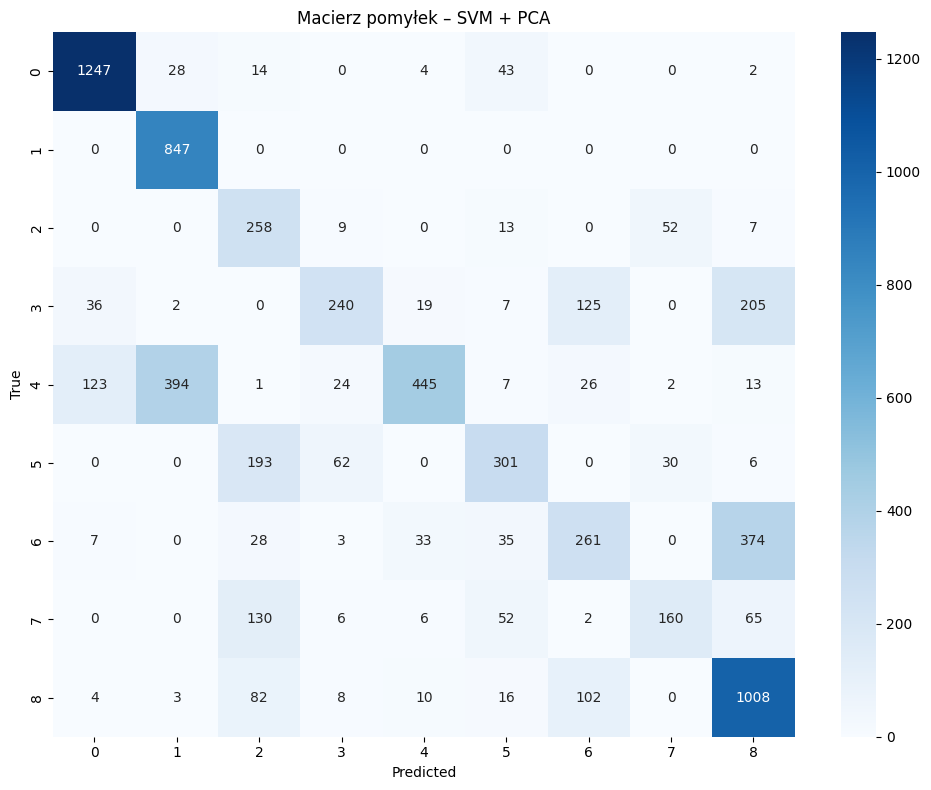

In [73]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 📉 PCA – Redukcja do 100 komponentów
pca = PCA(n_components=200, random_state=42)
X_train_pca = pca.fit_transform(X_train_svm_flat)
X_val_pca = pca.transform(X_val_svm_flat)
X_test_pca = pca.transform(X_test_svm_flat)

# 🧠 SVM – trenowanie modelu
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train_pca, y_train_svm)

# 📈 Ewaluacja na zbiorze testowym
y_pred_svm = svm_clf.predict(X_test_pca)
accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)
report_svm = classification_report(y_test_svm, y_pred_svm)
cm_svm = confusion_matrix(y_test_svm, y_pred_svm)

# 🖨️ Wyniki
print(f"SVM Test Accuracy: {accuracy_svm:.4f}")
print(report_svm)

# 🔳 Macierz pomyłek
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues")
plt.title("Macierz pomyłek – SVM + PCA")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 🔧 Pipeline: standaryzacja + PCA + SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=200, random_state=42)),
    ('svm', SVC())
])

# 🧪 Parametry do GridSearchCV
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 0.01, 0.001],
    'svm__kernel': ['rbf', 'linear']
}

# ⚙️ GridSearchCV
grid_search_svm = GridSearchCV(
    estimator=pipeline_svm,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=10
)

# ⚠️ Używamy tylko 10% zbioru treningowego do szybkiego dopasowania
subset_size = int(X_train_svm_flat.shape[0])
X_subset = X_train_svm_flat[:subset_size]
y_subset = y_train_svm[:subset_size]

# ▶️ Dopasuj GridSearch
grid_search_svm.fit(X_subset, y_subset)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/Users/krzysztof/Studies/sem2/umwdm/project/UMwDM/tf-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Najlepsze parametry: {'svm__C': 1, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
Średnia dokładność (CV): 0.6265
Dokładność na zbiorze testowym (SVM + GridSearch): 0.6326


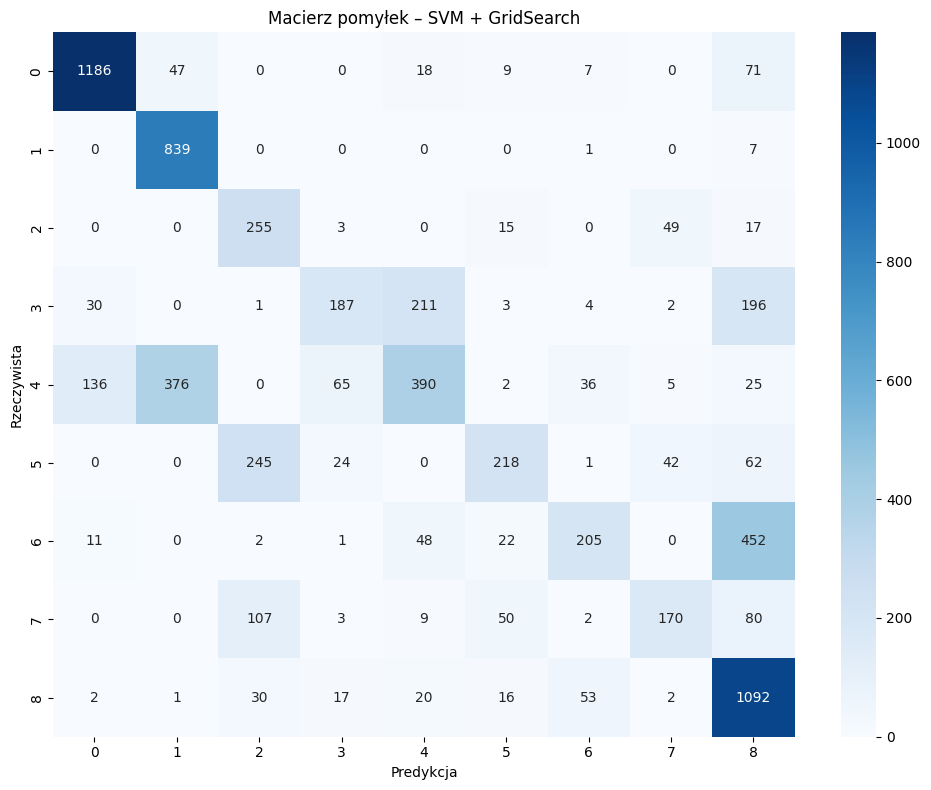

              precision    recall  f1-score      support
0              0.868864  0.886398  0.877543  1338.000000
1              0.664291  0.990555  0.795261   847.000000
2              0.398438  0.752212  0.520940   339.000000
3              0.623333  0.294953  0.400428   634.000000
4              0.560345  0.376812  0.450607  1035.000000
5              0.650746  0.368243  0.470334   592.000000
6              0.663430  0.276653  0.390476   741.000000
7              0.629630  0.403800  0.492041   421.000000
8              0.545455  0.885645  0.675116  1233.000000
accuracy       0.632591  0.632591  0.632591     0.632591
macro avg      0.622726  0.581697  0.563638  7180.000000
weighted avg   0.647615  0.632591  0.606119  7180.000000


In [71]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📊 Wyniki GridSearch
best_params = grid_search_svm.best_params_
best_score = grid_search_svm.best_score_
print("Najlepsze parametry:", best_params)
print(f"Średnia dokładność (CV): {best_score:.4f}")

# 🧪 Ewaluacja na zbiorze testowym
y_pred_svm_grid = grid_search_svm.predict(X_test_svm_flat)
acc_svm_grid = np.mean(y_pred_svm_grid == y_test_svm)
print(f"Dokładność na zbiorze testowym (SVM + GridSearch): {acc_svm_grid:.4f}")

# 📄 Raport klasyfikacji
report = classification_report(y_test_svm, y_pred_svm_grid, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# 🔳 Macierz pomyłek
cm = confusion_matrix(y_test_svm, y_pred_svm_grid)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predykcja")
plt.ylabel("Rzeczywista")
plt.title("Macierz pomyłek – SVM + GridSearch")
plt.tight_layout()
plt.show()

print(df_report)